# Feature development notebook

## 1. Background and object probability density function estimation

Image segmentation requires some knowledge of the background and intensity probability density functions

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

from skimage.io import imread

#
from scipy.optimize import curve_fit
from scipy.stats import *

In [49]:
def computeHist(image_list, correct=False, bp=np.ones(96), at=np.ones(512)):
    N = len(image_list)
    h = np.zeros(255)
    bins = bins = np.arange(0,256)
    x = np.array([])
    
    for idx in range(0,N):
        # read image
        image = imread(image_list[idx],as_grey = True)
#         if correct:
#             image = removeBPR(image, bp, at)
        x = np.hstack((x,image.flatten()))
        # compute histogram
        hi = np.histogram(image[:],bins)

        # add it to total
        h += hi[0]
        
    return (h, bins, x) 

10
116
270
5701632


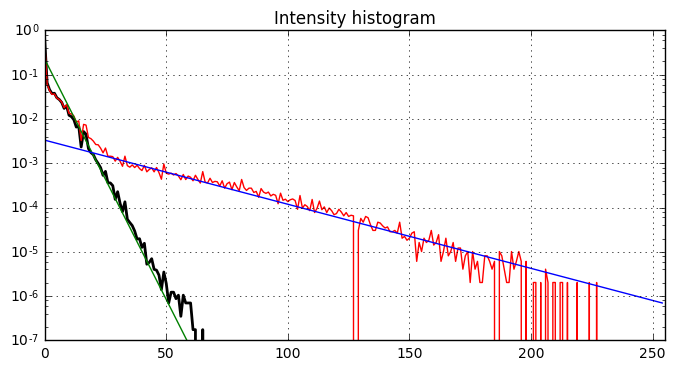

In [110]:
image_list_1 = glob('/home/pvt/Workspace/multibeam-classification/dataset-1/*raw.png')
print len(image_list_1)
image_list_2 = glob('/home/pvt/Workspace/multibeam-classification/dataset-2/*raw.png') # window set to 2.25m to 11.25m
print len(image_list_2)
image_list_3 = glob('/home/pvt/Workspace/multibeam-classification/dataset-3/*raw.png') # 
print len(image_list_3)

h, h_bins, x = computeHist(image_list_2)

print len(x)
# print np.sum(hist[0])/49152

plt.figure(figsize=(8,4))
# ax = plt.subplot(1,2,1)
plt.plot(h_bins[:-1], h/np.sum(h),color='k',linewidth=2.0)
plt.xlim([0,255])
# plt.ylim([1e-1,1e2])
# plt.yscale('log')
# plt.grid()
# plt.title('Intensity histogram')

h, h_bins, x = computeHist(image_list_1)
# ax = plt.subplot(1,2,2)
plt.plot(h_bins[:-1], h/np.sum(h),color='r')
plt.xlim([0,255])
plt.ylim([1e-7,1e0])
plt.yscale('log')
plt.grid()
plt.title('Intensity histogram')

de = 0.9*expon.pdf(h_bins[:-1],0, 4)
plt.plot(h_bins[:-1], de,color='g')
de = 0.1*expon.pdf(h_bins[:-1],0, 30.0)
plt.plot(h_bins[:-1], de,color='b')


In [116]:
threshold = 50.0
p = expon.cdf(threshold, loc=0, scale=4.0)
q = 1 - expon.cdf(threshold, loc = 0, scale = 30.0)
print p
print q

0.999996273347
0.188875602838


params: (-4.4615679282910081e-11, 2.2207962361735021)


(0, 50)

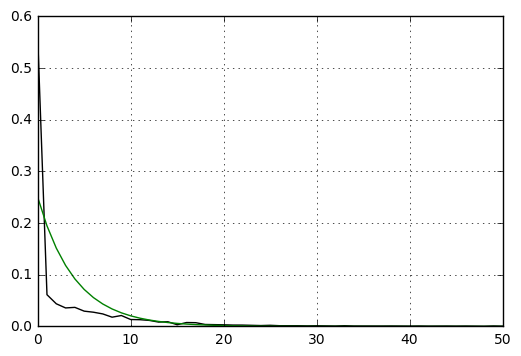

In [118]:
# out = expon.fit(x)
print 'params:',out
plt.plot(h_bins[:-1], h/np.sum(h),color='k')
# de = expon.pdf(h_bins[:-1],out[0], out[1])
de = expon.pdf(h_bins[:-1], 0, 4.0)
plt.plot(h_bins[:-1],de,color='g')
plt.grid()
plt.xlim([0,50]) 

116
270
5701632
(-4.4615679282910081e-11, 2.2207962361735021)
(0.20072374792176012, -1.9854993381079233e-29, 2.2602896668274912)


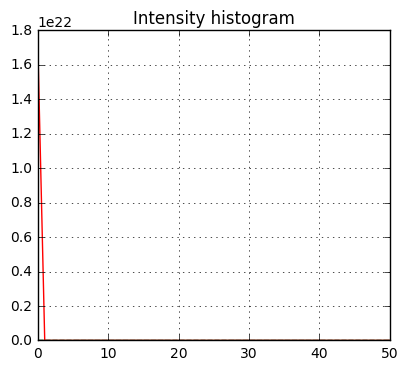

In [67]:
out = weibull_min.fit(x)
print 'weibull_min:',out
de = weibull_min.pdf(h_bins[:-1],out[0],out[1])
plt.plot(h_bins[:-1], h/np.sum(h),color='k')
plt.plot(h_bins[:-1],de,color='r')

## 2. Segmentation using Markov Random Fields

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

from skimage.io import imread
from scipy.signal import convolve2d

# from scipy.optimize import curve_fit
# from scipy.stats import cauchy, chi2, erlang, expon, genexpon, ncx2, poisson, powerlaw, rayleigh

In [ ]:
image_list = glob('/home/pvt/Workspace/multibeam-classification/dataset-1/*raw.png') # window set to 2.25m to 11.25m
print len(image_list)

plt.figure(figsize=(48,24))
for i in range(0,10):
    
    img = imread(image_list[i], as_grey=True)
    plt.subplot(10,1,i+1)
    plt.imshow(img.transpose())#,vmin=0,vmax=255.0)
    plt.title(i)

    
print np.amin(img), np.amax(img)

In [ ]:
def computeEnergy(u, uth, p, q, p00, p11, alpha, beta, n, m):
    """
    Returns two images (one for each label assignment) containing the likelihood energies for each pixel.
       
    u:     the prior labeled image
    uth:   thresholded image (z>zt?) 
    p:     p(z<z_t|0)
    q:     p(z>z_t|1)
    p00:   p(l^n=0|l^(n-1)=0)
    p11:   p(l^n=1|l^(n-1)=1)
    alpha: 1st order clique energy weight 
    beta:  2st order clique energy weight 
    n:     neighborhood size (range)
    m:     neighborhood size (bearing)
    """
    
    # assert n, m are odd
    assert (n %2 !=0) is True, 'range size must be odd'
    assert (m %2 !=0) is True, 'bearing size must be odd'
    
    u_0 = np.zeros_like(u) # energy assuming 'background' label
    u_1 = np.zeros_like(u) # energy assuming 'object' label
    
    # assert u is either 0 or 1
    ones = np.ones_like(u) # used for indicator function
    
    # prior energy
    u_0 -= np.log((ones-uth)*p + uth*(1-q))
    u_1 -= np.log((ones-uth)*(1-p) + uth*q)
    
    # 1st order cliques
    u_0 -= alpha*np.log((ones-u)*p00 + u*(1-p00))
    u_1 -= alpha*np.log((ones-u)*(1-p11) + u*p11)
    
    # 2nd order cliques
    # use convolution to compute clique energies
    # scipy.signal.convolve2d(in1, in2, mode='full', boundary='fill', fillvalue=0)[source]¶
    kernel = beta*np.ones((n,m))
    # replace kernel with cauchy kernels in range
    kernel[n/2,m/2] = 0 # we care only about the neighborhood
    
    # for 2nd order cliques, the only elements that count are those with the same label as the argument
    u_0 -= convolve2d((ones-u), kernel,'same')
    u_1 -= convolve2d(u, kernel,'same')
        
    return (u_0, u_1)
    

In [ ]:
img = imread(image_list[2], as_grey=True)
img = img.astype(np.float64)/255.0
print np.amax(img)

p = 0.99
q = 0.9
p00 = 0.95
p11 = 0.990
alpha = 1
beta = 0.5
n = 5
m = 5

u = 1.0*(img>0.2)
uth = u

print np.amin(u),np.amax(u)
print np.amin(uth),np.amax(uth)

(u_0, u_1) = computeEnergy(u, uth, p, q, p00, p11, alpha, beta, n, m)
print 'u_0:',np.amin(u_0),np.amax(u_0)
print 'u_1:',np.amin(u_1),np.amax(u_1)


plt.figure(figsize=(16,8))
plt.subplot(5,1,1)
plt.imshow(u_0.transpose())#,vmin=0,vmax=255.0)
plt.title('u_0')

plt.figure(figsize=(16,8))
plt.subplot(5,1,2)
plt.imshow(u_1.transpose())#,vmin=0,vmax=255.0)
plt.title('u_1')

u_r = u_1<u_0

plt.figure(figsize=(16,8))
plt.subplot(5,1,3)
plt.imshow(u_r.transpose())#,vmin=0,vmax=255.0)
plt.title('u_r')

plt.figure(figsize=(16,8))
plt.subplot(5,1,4)
plt.imshow(uth.transpose())#,vmin=0,vmax=255.0)
plt.title('uth')

plt.figure(figsize=(16,8))
plt.subplot(5,1,5)
plt.imshow((u_r-uth).transpose())#,vmin=0,vmax=255.0)
plt.title('diff')


In [ ]:
img = imread(image_list[9], as_grey=True)
img = img.astype(np.float64)/255.0

plt.figure(figsize=(16,8))
plt.imshow(img.transpose())

p = 0.9
q = 0.5
p00 = 0.99
p11 = 0.95
alpha = 0.5
beta = 1.0
n = 5
m = 5

u = 1.0*(img>0.1)
uth = u

plt.figure(figsize=(16,8))
plt.imshow(u.transpose())


plt.figure(figsize=(2*16,2*8))
for i in range(1,11):

    u = 1.0*u
    (u_0, u_1) = computeEnergy(u, uth, p, q, p00, p11, alpha, beta, n, m)
    u_prev = (u>0)
    u = (u_1<u_0)
    
    # update transition probability estimates
    n00 = np.sum(1-u[u_prev<1])
    print n00
    n01 = np.sum(u[u_prev<1])
    print n01
    n10 = np.sum(1-u[u_prev])
    print n10
    n11 = np.sum(u[u_prev])
    print n11
    
    p00e = n00/(n00+n10+0.0)
    print 'p00:',p00e
    p11e = n11/(n11+n01+0.0)
    print 'p11:',p11e
    
    assert (n00+n01+n10+n11==49152)
    
    print '---'
    
    plt.subplot(10,1,i)
    plt.imshow((u).transpose())#,vmin=0,vmax=255.0)

plt.show()

In [ ]:
image_list = glob('/home/pvt/Workspace/multibeam-classification/dataset-1/*raw.png') # window set to 2.25m to 11.25m
print len(image_list)
idx = np.random.randint(0,len(image_list))
print 'image:',idx
img = imread(image_list[idx], as_grey=True)
img = img.astype(np.float64)/255.0

plt.figure(figsize=(16,8))
plt.imshow(img.transpose())

# p = 0.99
# q = 0.5
# p00 = 0.995
# p11 = 0.8

# k = 2 # alpha = k*beta

# n = 7 # range
# m = 3 # bearing

# p,q values from page 12
p   = 0.97 # p(z<zt|0)
q   = 0.8 # p(z>zt|1)
p00 = 0.995 # 0>0
p11 = 0.25   # 1>1

beta = 1.0
k = 1.0 # alpha = k*beta

n = 5  # range
m = 3  # bearing

min_size = 0.5*(n*m -1 -(1/beta)*np.log(q/(1-q))-k*np.log(p11/(1-p00)))
print 'r+s>',min_size

u = 1.0*(img>0.13)
uth = u

plt.figure(figsize=(16,8))
plt.imshow(u.transpose())
plt.title('initial estimate')

plt.figure(figsize=(16,8))
total_change = 10;
iter = 0

pe = np.zeros((100,2))

while (total_change>0):
    
    beta = min(2,beta+0.1)
    alpha = k*beta;
    
    u = 1.0*u
    (u_0, u_1) = computeEnergy(u, uth, p, q, p00, p11, alpha, beta, n, m)
    u_prev = (u>0)
    u = (u_1<u_0)
    
    # transition probability estimates
    n00 = np.sum(1-u[u_prev<1])
    n01 = np.sum(u[u_prev<1])
    n10 = np.sum(1-u[u_prev])
    n11 = np.sum(u[u_prev])
    print [[n00, n01],[n10, n11]]
    assert (n00+n01+n10+n11==49152)
    total_change = n01 + n10
    p00e = n00/(n00+n10+0.0)
    p11e = n11/(n11+n01+0.0)
#     p11 = p11e
    pe[iter,0] = p00e
    pe[iter,1] = p11e
    
    iter+=1;
    if iter>100:
        break
    
print 'done in',iter,'iterations'

print 'p00:',p00e
print 'p11:',p11e

plt.imshow((u).transpose())#,vmin=0,vmax=255.0)
plt.title('segmentation')
plt.show()

plt.plot(pe[:iter,0])
plt.plot(pe[:iter,1])